In [2]:
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from theano import shared,tensor
import time 
from datetime import datetime
from sklearn.metrics import mean_squared_error
import pickle
import joblib

#### 讀訓練和測試資料

In [3]:
df=pd.read_csv('/kaggle/input/historyapr/EPA_OD_202304.csv')
truth=pd.read_csv('/kaggle/input/history-may/EPA_OD_202305.csv')
df=df[df['PublishTime']>='2023-04-28 00:00:00']
df.head()

,SiteName,County,AQI,Pollutant,Status,SO2,CO,CO_8hr,O3,O3_8hr,...,NO2,NOx,NO,WindSpeed,WindDirec,PublishTime,SO2_AVG,Longitude,Latitude,SiteId
48664,金門,金門縣,70.0,細懸浮微粒,普通,2.9,0.27,0.2,50.3,58.3,...,6.4,6.7,0.3,1.9,82,2023-04-28 00:00:00,2.0,118.312256,24.432133,77
48665,埔里,南投縣,59.0,細懸浮微粒,普通,1.0,0.37,0.3,34.1,NaN,...,7.4,8.8,1.4,0.3,319,2023-04-28 00:00:00,1.0,120.967903,23.968842,72
48666,宜蘭,宜蘭縣,37.0,NaN,良好,0.5,0.26,0.2,24.8,40.7,...,5.1,5.4,0.2,0.5,252,2023-04-28 00:00:00,0.0,121.746394,24.747917,65
48667,永和,新北市,57.0,二氧化氮,普通,0.8,1.87,1.0,0.7,15.1,...,39.2,79.5,40.3,0.2,295,2023-04-28 00:00:00,0.0,121.516306,25.017000,70
48668,富貴角,新北市,44.0,NaN,良好,0.8,0.20,0.1,35.9,48.9,...,3.4,3.4,0.0,1.9,147,2023-04-28 00:00:00,0.0,121.536569,25.296817,84


#### 資料集有缺失資料

In [4]:
features=['PM2.5_AVG','PM10','AQI','PM2.5','SiteId']
for feature in features:
    print(f"{feature} has nan value: ",df[feature].isna().any())

PM2.5_AVG has nan value:  True
PM10 has nan value:  True
AQI has nan value:  True
PM2.5 has nan value:  True
SiteId has nan value:  False


#### 資料前處理：處理空白值

In [5]:
def preprosessing(data):
#     data.dropna(inplace=True)
#     data.fillna(value=data.mean(), inplace=True)
    data=data.fillna(method='ffill')
    return data
df=preprosessing(df)

#### 資料前處理：標準化

In [6]:
def standardize(data):
    for feature in features[:-2]:
        data[feature] =( data[feature] - data[feature].mean() ) / data[feature].std()
    return data
df=standardize(df)

#### 訓練Multi-Linear Regression Model

In [7]:
with pm.Model() as model:
    X0=pm.Data('X0',df[features[0]].values)
    X1=pm.Data('X1',df[features[1]].values)
#     X2=pm.Data('X2',df[features[2]].values)
    y=pm.Data('y',df[features[3]].values)
    alpha=pm.Normal('alpha',mu=0,sd=10)
    beta=pm.Normal('beta',sd=10,shape=2)
    esp=pm.HalfNormal('esp',sd=10)
    mu=pm.Deterministic('mu',alpha+beta[0]*X0+beta[1]*X1)
    y_pred=pm.Normal('y_pred',mu=mu,sd=esp,observed=y)
    trace=pm.sample(3000)
    ppc=pm.sample_posterior_predictive(trace)

/opt/conda/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/opt/conda/lib/python3.10/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


#### Save Trace and Posterior Predictive

In [8]:
pklname="trace"+".pkl"
pklppc="predict"+".pkl"
with open(pklname, 'wb') as file:
    pickle.dump(trace, file)
with open(pklppc,'wb') as file:
    pickle.dump(ppc,file)

#### 利用模型結果預測PM2.5

In [9]:
def calculate_result(row):
    site=int(row['SiteId'])
    a=trace['alpha'].mean()
    b0=trace['beta'][0].mean()
    b1=trace['beta'][1].mean()
#     b2=trace['beta'][2].mean()
    result = a + b0 * row[features[0]]+  b1 * row[features[1]]
#     result = a + b0 * row[features[0]]+  b1 * row[features[1]] + b2 * row[features[2]]
    return result
df['result'] = df.apply(calculate_result, axis=1)

#### Training Data MSE

In [10]:
mse = mean_squared_error(df['PM2.5'].values, df['result'].values)
print("training mse:",mse)

training mse: 14.359684783730845


#### Testing Data MSE

In [11]:
truth=preprosessing(truth)
truth=standardize(truth)
truth['result'] = truth.apply(calculate_result, axis=1)
mse = mean_squared_error(truth['PM2.5'].values, truth['result'].values)
print("testing mse:",mse)

testing mse: 28.29455499329064


#### Posterior Predictive Check

/opt/conda/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


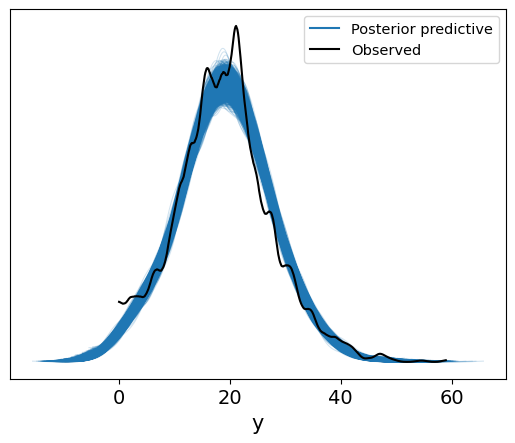

In [12]:
az.plot_ppc(az.from_pymc3(trace,posterior_predictive=ppc),mean=False)
plt.xlabel('y')
plt.savefig("posterior predictive")

#### R Square

In [13]:
print("for training data:")
print(az.r2_score(df['PM2.5'].values, df['result'].values))
print()
print("for testing data:")
print(az.r2_score(truth['PM2.5'].values, truth['result'].values))


for training data:
r2        0.805077
r2_std    0.000000
dtype: float64

for testing data:
r2        0.781518
r2_std    0.000000
dtype: float64


#### Expected Log Pointwise Density

In [14]:
elpd=az.loo(trace,pointwise=True,scale="deviance")
elpd

/opt/conda/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 6000 posterior samples and 3773 observations log-likelihood matrix.

             Estimate       SE
deviance_loo 20757.46   115.53
p_loo            5.49        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3773  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

#### Save Model

In [15]:
filename = "linear_model.joblib"
joblib.dump(model, filename)

['linear_model.joblib']